# Cooking for dummies

## Abstract

Eating is one of the main actions we do everyday. But cooking does not seem to be as core as eating, as precooked food seem to be more popular than ever. Moreover, with the restructuring of the society in terms of gender, cooking lessons are now meant for specialists that intend to work as cooks. It seems relevant to study the recipes found online to help guiding the nowadays willing-to-cook beginner to choose the more appropriate recipe and to understand the calories indications in terms of understandable, tangible notions.

Can recipes be grouped into meaningful classes in terms of ingredients? Are these groups characterized by their distributions in carbs,fat and proteins?

The idea of the study is to group the recipes, not based on the classic starter/main course/dessert but on a more realistic grouping based on the food groups (vegetables,dairy,cereals,...) used in the recipes. The main idea is to get the ingredients by **Natural Language Processing**, and then use a **k-means clustering algorithm** to define our groups of recipes. We can then study their distributions regarding their calories and try to **characterize our groups by carb, fat and proteins distribution**. we finally use **propensity scores** to assess how much the characterization by fat,carb,proteins is relevant.

In [1]:
import os
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re

%matplotlib inline
pd.options.display.max_rows = 10
pd.options.display.max_colwidth = 1000

## Dataset

We take our data from:
* Cooking recipes: infolab.stanford.edu/~west1/from-cookies-to-cooks/recipePages.zip 
* infolab.stanford.edu/~west1/from-cookies-to-cooks/recipeInfo.tar.gz


In [2]:
if("reload" not in globals()):
    reload = True
    
if(reload):
    db = pd.read_excel('recipeInfo/recipeInfo.xls',encoding='utf8')
    
    db2 = db.dropna(subset=['ingredients_bag-of-words'],axis=0)
    
    reload = False

db2.head()

,domain,url,kcal_total,kcal_carb,kcal_fat,kcal_protein,mg_sodium,mg_cholesterol,title,title_bag-of-words,ingredients_list,ingredients_bag-of-words
0,recipes.sparkpeople.com,http://recipes.sparkpeople.com/recipe-detail.asp?recipe=1191905,257.1,220,7.2,21.2,95.4,2.5,Easy Light Chocolate Milkshake Recipe,chocolate easy light milkshake recipe,"put one half cup of milk, 4 tablespoons of chocolate syrup, Vanilla extract and Ice to taste in whatever your using to blend it. Blend until satisfied with the texture and serve.|Now what are you waiting for?|go on! enjoy!","! , . 4 ? and are blend chocolate cup enjoy extract for go half ice in it milk now of on one put satisfied serve syrup tablespoons taste texture the to until using vanilla waiting what whatever with you your"
1,foodnetwork.com,http://www.foodnetwork.com/recipes/rachael-rays-tasty-travels/lamb-stew-recipe/index.html,?,?,?,?,?,?,Lamb Stew Recipe : : Recipes : Food Network,: food lamb network recipe recipes stew,"5 yellow onions|2 turnips|5 carrots|1 stalk fennel|1 cup cooking oil, divided|1 1/2 gallons chicken stock|1/2 head garlic|1/4 gallon orange juice|1/4 gallon apple cider|1/4 cup coriander seeds|1/8 cup fennel seeds|1 star anise|2 tablespoons cumin seeds|1/8 cup orange zest|1 teaspoon salt|1/2 tablespoon freshly ground black pepper|1 leg of lamb|3 cups dry white wine|Salt and freshly ground pepper|Your choice fresh herbs, minced, to taste",", 1 1\/2 1\/4 1\/8 1 1\/2 2 3 5 and anise apple black carrots chicken choice cider cooking coriander cumin cup cups divided dry fennel fresh freshly gallon gallons garlic ground head herbs juice lamb leg minced of oil onions orange pepper salt seeds stalk star stock tablespoon tablespoons taste teaspoon to turnips white wine yellow your zest"
2,foodnetwork.com,http://www.foodnetwork.com/recipes/paula-deen/chocolate-bread-pudding-recipe/index.html,?,?,?,?,?,?,Chocolate Bread Pudding Recipe : Paula Deen : Recipes : Food Network,: bread chocolate deen food network paula pudding recipe recipes,"1 (1-pound) loaf French or Italian bread, cubed|3 cups milk|1/4 cup heavy cream|1/2 cup coffee flavored liqueur|1 cup sugar|1 cup packed light brown sugar|1/4 cup cocoa powder|1 tablespoon vanilla extract|2 teaspoons almond extract|1 1/2 teaspoon cinnamon|6 eggs, lightly beaten|8 ounces semisweet chocolate, grated|Whipped cream (optional)",", -lrb- -rrb- 1 1-pound 1\/2 1\/4 1 1\/2 2 3 6 8 almond beaten bread brown chocolate cinnamon cocoa coffee cream cubed cup cups eggs extract flavored french grated heavy italian light lightly liqueur loaf milk optional or ounces packed powder semisweet sugar tablespoon teaspoon teaspoons vanilla whipped"
3,cdkitchen.com,http://www.cdkitchen.com/recipes/recs/32/Snowball_Cookies_II54545.shtml,?,?,?,?,?,?,Snowball Cookies II Recipe,cookies ii recipe snowball,1/2 cup powdered sugar|1/3 cup butter or margarine|2 cups bisquick baking mix|1/2 cup chopped nuts|1 teaspoon almond extract|2 tablespoons water|powdered sugar,1 1\/2 1\/3 2 almond baking bisquick butter chopped cup cups extract margarine mix nuts or powdered sugar tablespoons teaspoon water
4,cdkitchen.com,http://www.cdkitchen.com/recipes/recs/38/Old_Fashioned_Butterscotch_Pie42680.shtml,192,120,63,12,?,?,Old Fashioned Butterscotch Pie Recipe #31698,# 31698 butterscotch fashioned old pie recipe,1 1/2 cup brown sugar|1 cup water|3 eggs|4 tablespoons flour|1 cup milk|4 tablespoons butter|1 teaspoon vanilla extract|1/4 teaspoon salt|1/2 teaspoon cream of tartar|4 tablespoons granulated or powdered sugar,1 1\/2 1\/4 1 1\/2 3 4 brown butter cream cup eggs extract flour granulated milk of or powdered salt sugar tablespoons tartar teaspoon vanilla water


This data represents recipes gathered from several cooking websites. It contains recipes entries with info such as the calories (fat,proteins,carb) and the ingredients.

Our main focus will be the ingredients list of each recipe, from which we intend to collect an exhaustive list of ingredients.

In the following code, we extract from the database what we are interested in:
* the domain, ie the website from which the recipe is taken
* the kcal columns (total,fat,carb,protein): we take recipes for which the calories are indicated, as this is the main focus of our analysis. Moreover we avoid recipes with unrealistic amounts of calories (>2500)
* the ingredients_list column, that we then filter via Natural Language Processing

In [3]:
db_recipes = db2[['domain','kcal_total','kcal_carb','kcal_protein',
                  'kcal_fat','ingredients_list']].copy(deep=True)
db_recipes['ingredients_list'] = db_recipes['ingredients_list'].str.lower()

db_recipes = db_recipes[db_recipes['kcal_total']!='?']
db_recipes = db_recipes[db_recipes['kcal_protein']!='?']
db_recipes = db_recipes[db_recipes['kcal_carb']!='?']
db_recipes = db_recipes[db_recipes['kcal_fat']!='?']
db_recipes['kcal_total'] = db_recipes['kcal_total'].apply(lambda x: int(float(x)))
db_recipes['kcal_fat'] = db_recipes['kcal_fat'].apply(lambda x: int(float(x)))
db_recipes['kcal_carb'] = db_recipes['kcal_carb'].apply(lambda x: int(float(x)))
db_recipes['kcal_protein'] = db_recipes['kcal_protein'].apply(lambda x: int(float(x)))
db_recipes = db_recipes[db_recipes['kcal_total']<=2500]

db_recipes

,domain,kcal_total,kcal_carb,kcal_protein,kcal_fat,ingredients_list
0,recipes.sparkpeople.com,257,220,21,7,"put one half cup of milk, 4 tablespoons of chocolate syrup, vanilla extract and ice to taste in whatever your using to blend it. blend until satisfied with the texture and serve.|now what are you waiting for?|go on! enjoy!"
4,cdkitchen.com,192,120,12,63,1 1/2 cup brown sugar|1 cup water|3 eggs|4 tablespoons flour|1 cup milk|4 tablespoons butter|1 teaspoon vanilla extract|1/4 teaspoon salt|1/2 teaspoon cream of tartar|4 tablespoons granulated or powdered sugar
7,allrecipes.com,183,16,51,115,"8 eggs|1 tablespoon mayonnaise|2 tablespoons prepared dijon-style mustard|1 teaspoon dried dill weed|1 teaspoon paprika|1/2 red onion, minced|salt and pepper to taste"
8,food.com,1,0,0,0,1 cup red clover blossoms|2 tablespoons mint (spearmint or peppermint)|4 cups water
9,food.com,351,154,38,157,2 cups vanilla ice cream or 2 cups soy ice cream|1 1/4 cups 2% low-fat milk or 1 1/4 cups soymilk|1/4 teaspoon mint extract|8 drops green food coloring
...,...,...,...,...,...,...
65526,myrecipes.com,148,73,30,45,"2 cups (8 ounces) shredded part-skim mozzarella cheese, divided|1/2 cup fat-free sour cream|1/4 cup (1 ounce) grated fresh parmesan cheese, divided|1/4 teaspoon black pepper|3 garlic cloves, crushed|1 (14-ounce) can artichoke hearts, drained and chopped|1 (8-ounce) block 1/3-less-fat cream cheese, softened|1 (8-ounce) block fat-free cream cheese, softened|1/2 (10-ounce) package frozen chopped spinach, thawed, drained, and squeezed dry|1 (13.5-ounce) package baked tortilla chips (about 16 cups)"
65530,food.com,160,124,37,7,2 cups black beans|2 cups light red beans|2 cups pinto beans|1 (5 cup) bag frozen mixed peppers (green/red/yellow)|2 (29 ounce) cans tomato sauce
65531,food.com,613,306,111,198,"1 tablespoon olive oil|1 large brown onion (finely chopped)|2 garlic cloves (crushed or minced)|1 1/4 cups dried split green peas (dried peas rinsed)|2 cups chicken stock|2 cups water (cold)|2 tablespoons lemon juice|125 g bacon (rashers shortcut rind removed)|1/2 teaspoon paprika (to serve)|4 crusty bread rolls (to serve, i used bacon and cheese)"
65532,yummly.com,858,432,20,333,6 bartlett pear (firm)|750 mls dry red wine|1 vanilla bean (whole)|2 cinnamon sticks|2 bay leave|2 cups sugar|16 ozs mascarpone cheese|12 cup whipping cream|1 pinch cinnamon|12 cup icing sugar|2 tbsps butter


## Natural Language Processing

To process the ingredients_list column and extract a relevant list of ingredients, we need a database of foods. We could not find any satisfying database so we started from http://openfood.schoolofdata.ch/food-composition-ch/, to which we manually added words that could appear in recipes but were not in the database:
* different cheese names (gorgonzola,...)
* different pasta names (spaghetti,...)
* different types of sauce (ketchup,...)
* usual types of meat (bacon,...)

The relevant ingredients data is saved under foods_db.csv.

Each ingredient also has an entry food_group (Dairy, Vegetables, Cereals,...).

In [4]:
db_foods = pd.read_csv('recipeInfo/foods_db.csv',encoding='latin1')[['name','food_group']]
db_foods['name'] = db_foods['name'].str.lower()
db_foods['food_group'] = db_foods['food_group'].str.lower()

#sort by length
db_foods.index = db_foods['name'].str.len()
db_foods = db_foods.sort_index(ascending=False).reset_index(drop=True)

# create foods list
foods_list = db_foods['name'].tolist()

db_foods.head()

,name,food_group
0,mixed cereals and nuts,cereals & nuts
1,worcestershire sauce,condiment
2,jerusalem artichoke,vegetables
3,parmigiano-reggiano,dairy
4,macaroni and cheese,cereals & nuts


### The algorithm

The algorithm works as follows:
* for each ingredients_list (type:str) in the database:
    * remove from the string irrelevant words which can be confused with ingredients ('teaspoon' could be matched as 'tea', 'virgin' could be matched as 'gin',...)
    * for each food in our NLP database:
        * if we **identify** the word in the string, it is added to the list of ingredients and also deleted in the string


For the algorithm to work as correctly as possible, the following tricks are used:
* the list of foods is **sorted by decreasing length**. This way, if 'black pepper' is found, it is deleted from the string and then 'pepper' will not be identified as an ingredient
* To **identify** a food, we look for the word followed by a separator (' ', ',', '|') but also if it appears in its **plural form**, which implies taking into account the irregular plural forms ('berr-ies' for berr-y', 'tomato-es' for 'tomat-o',...).

In [5]:
non_foods_list = ['teaspsoon','teaspooons','teaspooon','teasopoon','teaspoons',
                  'teaspoon','teas.','virgin']

def match_foods(x):
    ret_list = []
    x_copy = x + ' '
    for non_food in non_foods_list:
        x_copy = x_copy.replace(non_food,'')
    for food in foods_list:
        if food.endswith('y'):
            if ((food+' ') in x_copy or (food+',') in x_copy or
            (food+'|') in x_copy or (food[:-1]+'ies') in x_copy or
            (food+'s') in x_copy):
                ret_list.append(food)
                x_copy = x_copy.replace(food[:-1],'///') 
        elif food.endswith('o'):
            if ((food+' ') in x_copy or (food+',') in x_copy or
            (food+'|') in x_copy or (food+'es') in x_copy or
            (food+'s') in x_copy):
                ret_list.append(food)
                x_copy = x_copy.replace(food[:-1],'///')
        elif food.endswith('h'):
            if ((food+' ') in x_copy or (food+',') in x_copy or
            (food+'|') in x_copy or (food+'es') in x_copy or
            (food+'s') in x_copy):
                ret_list.append(food)
                x_copy = x_copy.replace(food[:-1],'///')
        elif food.endswith('f'):
            if ((food+' ') in x_copy or (food+',') in x_copy or
            (food+'|') in x_copy or (food[:-1]+'ves') in x_copy or
            (food+'s') in x_copy):
                ret_list.append(food)
                x_copy = x_copy.replace(food[:-1],'///')   
        else: 
            if ((food+' ') in x_copy or (food+',') in x_copy or
            (food+'|') in x_copy or (food+'s') in x_copy):
                ret_list.append(food)
                x_copy = x_copy.replace(food,'///')
                
    return ret_list

db_recipes['ingredients'] = db_recipes['ingredients_list'].apply(match_foods)

We delete the recipes where no ingredients have been identified. It can happen for several reasons:
* the entry is invalid: the recipes have been automatically scraped from the websites, and it may happen that the ingredients part does not contain the right info
* all recipes found in the database are not food related. For instance there are some recipes for soap.

In [6]:
db_recipes['no_ingredients']=db_recipes['ingredients'].apply( lambda x: x==[])
db_recipes = db_recipes[~db_recipes['no_ingredients']]
db_recipes = db_recipes[['domain','kcal_total','kcal_carb','kcal_protein',
                  'kcal_fat','ingredients_list','ingredients']].reset_index(drop=True)
db_recipes.head()

,domain,kcal_total,kcal_carb,kcal_protein,kcal_fat,ingredients_list,ingredients
0,recipes.sparkpeople.com,257,220,21,7,"put one half cup of milk, 4 tablespoons of chocolate syrup, vanilla extract and ice to taste in whatever your using to blend it. blend until satisfied with the texture and serve.|now what are you waiting for?|go on! enjoy!","[chocolate, vanilla, milk]"
1,cdkitchen.com,192,120,12,63,1 1/2 cup brown sugar|1 cup water|3 eggs|4 tablespoons flour|1 cup milk|4 tablespoons butter|1 teaspoon vanilla extract|1/4 teaspoon salt|1/2 teaspoon cream of tartar|4 tablespoons granulated or powdered sugar,"[brown sugar, vanilla, butter, sugar, flour, cream, milk, salt, egg]"
2,allrecipes.com,183,16,51,115,"8 eggs|1 tablespoon mayonnaise|2 tablespoons prepared dijon-style mustard|1 teaspoon dried dill weed|1 teaspoon paprika|1/2 red onion, minced|salt and pepper to taste","[mayonnaise, paprika, mustard, pepper, onion, salt, dill, egg]"
3,food.com,1,0,0,0,1 cup red clover blossoms|2 tablespoons mint (spearmint or peppermint)|4 cups water,"[spearmint, mint]"
4,food.com,351,154,38,157,2 cups vanilla ice cream or 2 cups soy ice cream|1 1/4 cups 2% low-fat milk or 1 1/4 cups soymilk|1/4 teaspoon mint extract|8 drops green food coloring,"[ice cream, vanilla, milk, mint]"


## Exploratory Analysis

### Data origin

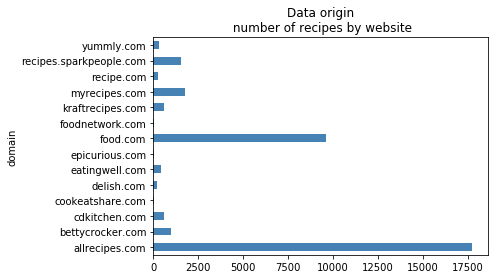

In [7]:
db_recipes.groupby(db_recipes['domain'])['kcal_total'].count().plot.barh(title="Data origin\n number of recipes by website", color=['steelblue'])
plt.show()

We first have a look at the origin of the data: it mostly comes from 3 websites (*allrecipes.com*, *food.com* and *foodnetwork.com*).

Note that we **do not** look at all the data (like mg_sodium, mg_cholesterol,...) because it is simply not all of use for our project.

### Occurencies of ingredients

In [8]:
count = [0]*len(foods_list)

def count_food(x):
    for food in x:
        count[foods_list.index(food)] += 1
db_recipes['ingredients'].apply(count_food)

db_foods['count'] = count
db_foods.head()

,name,food_group,count
0,mixed cereals and nuts,cereals & nuts,0
1,worcestershire sauce,condiment,1127
2,jerusalem artichoke,vegetables,2
3,parmigiano-reggiano,dairy,54
4,macaroni and cheese,cereals & nuts,3


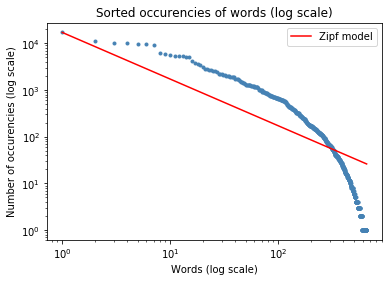

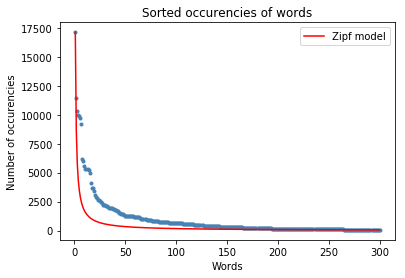

In [9]:
X = [x+1 for x in range(len(db_foods))]
Y = list(db_foods['count'])
Y.sort(reverse=True)
Y2 = [ Y[0]/(x+1) for x in range(len(db_foods))]


plt.figure()
plt.loglog(X,Y,'.', color='steelblue')
plt.loglog(X,Y2, color='red', label='Zipf model') # Zipf estimate
plt.xlabel('Words (log scale)')
plt.ylabel('Number of occurencies (log scale)')
plt.title('Sorted occurencies of words (log scale)')
plt.legend()
plt.show()

plt.figure()
plt.plot(X[:300],Y[:300],'.', color='steelblue')
plt.plot(X[:300],Y2[:300], color='red', label='Zipf model') # Zipf estimate
plt.xlabel('Words')
plt.ylabel('Number of occurencies')
plt.title('Sorted occurencies of words')
plt.legend()
plt.show()

We look at the occurencies of words. Considering that it is a large amount of textual data, we could expect our word distribution to respect the **Zipf Law** (https://en.wikipedia.org/wiki/Zipf%27s_law). It states that if we sort the words by their frequencies (*w_1*,...,*w_N*) such that *f_1*>...*f_N*, they will respect an inverse distribution: *f_i*=*1/i* for all *i*.

On this **logarithmic scale**, we observe that our distribution is relatively different. The frequencies do not decrease so sharply, and there is a smoother distribution of frequencies.

### Words by occurencies

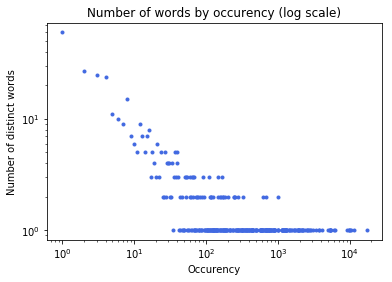

In [10]:
from collections import Counter

occ_counter = Counter(list(db_foods['count']))
X = [ x for (x,_) in occ_counter.most_common()]
Y = [ y for (_,y) in occ_counter.most_common()]

plt.figure()
plt.loglog(X,Y,'.',color='royalblue')
plt.xlabel('Occurency')
plt.ylabel('Number of distinct words')
plt.title('Number of words by occurency (log scale)')
plt.show()

In this graph, we illustrate how **a lot of words are used a few times**, while for a high occurency only a few words are used that many often.

This also means that at some point we will have to decide if it reasonable to keep ingredients that are only mentioned one rare time, in order to decrease the size of the data.

### Cumulative words by occurency

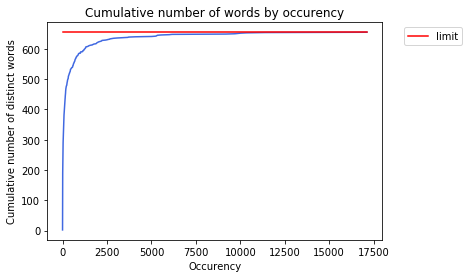

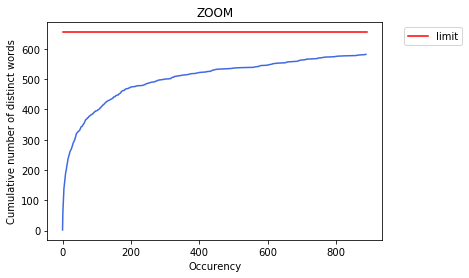

In [11]:
occ_counter = Counter(list(db_foods['count']))
X = [ x for (x,_) in sorted(occ_counter.items())]
Y = [ y for (_,y) in sorted(occ_counter.items())]
for i in range(1,len(Y)):
    Y[i] += Y[i-1]

    
plt.plot(X,Y,color='royalblue')
plt.plot((1,X[-1]),(Y[-1],Y[-1]), color='red', label='limit')
plt.xlabel("Occurency")
plt.ylabel("Cumulative number of distinct words")
plt.title('Cumulative number of words by occurency')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

plt.figure()
plt.plot(X[:250],Y[:250],color='royalblue')
plt.plot((1,X[250]),(Y[-1],Y[-1]), color='red', label='limit')
plt.xlabel("Occurency")
plt.ylabel("Cumulative number of distinct words")
plt.title('ZOOM')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

On this graph we observe that the number of words with less than a given number of occurencies quickly converges to its limit, meaning that **there are few words with a lot of occurencies**.

### A look at the calories

In [12]:
db_recipes['kcal_total'].describe()

count    34217.000000
mean       325.904989
std        254.316891
min          0.000000
25%        159.000000
50%        272.000000
75%        422.000000
max       2495.000000
Name: kcal_total, dtype: float64

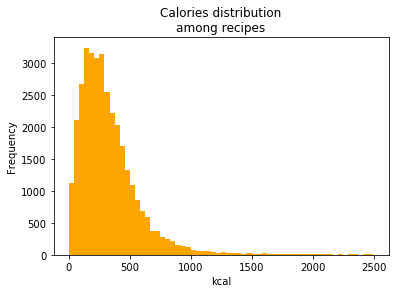

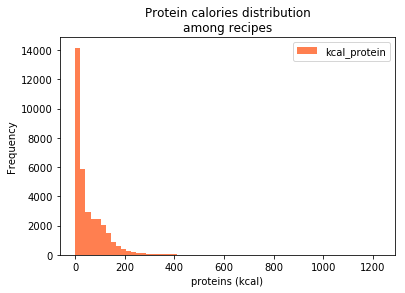

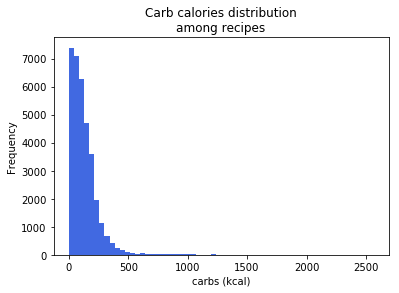

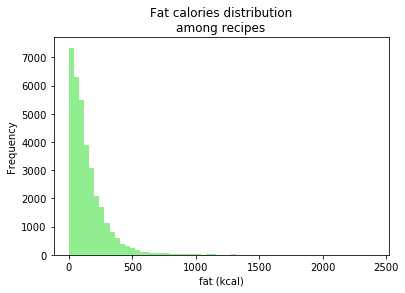

In [13]:
db_recipes['kcal_total'].plot.hist( bins=60, color='orange',title='Calories distribution\namong recipes')
plt.xlabel('kcal')
plt.show()

db_recipes[['kcal_protein']].plot.hist( bins=60, color='coral',title='Protein calories distribution\namong recipes')
plt.xlabel('proteins (kcal)')
plt.show()

db_recipes['kcal_carb'].plot.hist( bins=60, color='royalblue',title='Carb calories distribution\namong recipes')
plt.xlabel('carbs (kcal)')
plt.show()

db_recipes['kcal_fat'].plot.hist( bins=60, color='lightgreen',title='Fat calories distribution\namong recipes')
plt.xlabel('fat (kcal)')
plt.show()

As stated before, we focus on recipes with less than 2500 kcal.

We see that the calories distribution is concentrated around its mean.
More than 75% of the recipes count less than 422 kcal.

The repartition for carbs, fat and proteins is quite similar, very dense near the mean. We observe however that proteins tend to count as fewer calories among recipes than carbs and fat.

## Grouping the recipes

To visually represent the data in calories graphes, we want to group the recipes in several groups. We would have liked to use some kind of well-known grouping such as starters, main plates, desserts, but the database does not contain this info.

To group the recipes, we choose to use the data of the ingredients food_groups. Each ingredient belongs to a food_group among the 11 possible (vegetables, meat,...). For each recipe, we put to 1 each food group to which at least one ingredient of the recipe belongs to. Thus each recipe is assigned a tuple {0,1}^11.

We then use a clustering algorithm to create the final groups

### Create the data

The data of group belonging for each recipe is set in the matrix M.

In [14]:
groupe_idx = {'beverages':0, 'cereals & nuts':1, 'confectioneries':2,
             'condiment':3, 'dairy':4, 'eggs':5, 'fats & oils':6,
             'fruits':7, 'meat':8, 'herbs & spices':9, 'vegetables':10}
db_foods['group_idx'] = db_foods['food_group'].apply( lambda x: groupe_idx[x])
db_foods

,name,food_group,count,group_idx
0,mixed cereals and nuts,cereals & nuts,0,1
1,worcestershire sauce,condiment,1127,3
2,jerusalem artichoke,vegetables,2,10
3,parmigiano-reggiano,dairy,54,4
4,macaroni and cheese,cereals & nuts,3,1
...,...,...,...,...
650,yam,vegetables,47,10
651,cod,meat,106,8
652,elk,meat,4,8
653,fig,fruits,44,7


In [15]:
M = [[0 for _ in range(11)] for _ in range(len(db_recipes))]
for i in range(len(db_recipes)):
    for food in db_recipes.loc[i,'ingredients']:
        j = db_foods.loc[db_foods.index[db_foods['name']==food][0],'group_idx']
        M[i][j] = 1

### Clustering algorithm

We use a **K-means clustering** algorithm to create our recipe groups.
Starting from K random means, we assign each recipe to the closest mean (the distance being defined as the sum of differences over the 11 elements). Then each mean is updated to correspond to the effective mean of the elements assigned to this mean.

In practice, though recipes get values in {0,1}^11, the **means have real values** in [0,1]^11 to get the best possible clustering.

Moreover, after having tested different values of K to study the convergence of the groups, we set the **option to fix the initial means**, for reproducibility.


In [16]:
import random as rd

def d(x,y):
    dist=0
    for i in range(len(x)):
        dist += abs(x[i]-y[i])
    return dist

def k_cluster(k,M,means=[]):
    if means == []:
        means = [[rd.randint(0,1) for _ in range(11)] for _ in range(k)]
    assign = [0 for _ in range(len(M))]
    fixed_point = False
    nb_turns = 0
    
    def update_assign(i):
        updated = False
        pre_mean = d(M[i],means[assign[i]])
        for j in range(k):
            if d(M[i],means[j])<pre_mean:
                assign[i]=j
                pre_mean = d(M[i],means[assign[i]])
                updated = True
        return updated
    
    def update_mean(j):
        number_assign = 0
        new_mean = [0 for _ in range(11)]
        for i in range(len(M)):
            if assign[i]==j:
                number_assign += 1
                for l in range(11):
                    new_mean[l] += M[i][l]
        for l in range(11):
            new_mean[l] = new_mean[l]/number_assign
            
        means[j]=new_mean
                
    
    while not(fixed_point):
        nb_turns += 1
        fixed_point = True
        #update assign
        for i in range(len(M)):
            if update_assign(i):
                fixed_point = False
                
        #update means
        for j in range(k):
            update_mean(j)
    
    print("Convergence in ",nb_turns,"turns")
    return means,assign

# Fixed initial means after tests
init_means = [[0,1,1,0,1,1,0,0,0,1,0],
              [0,1,1,0,1,0,0,1,0,1,0],
              [0,1,0,1,1,0,0,0,1,1,1],
              [0,0,0,1,0,0,1,0,1,1,1]]

means,recipe_group = k_cluster(4,M,init_means)

Convergence in  14 turns


Note that here the initial means are fixed because the tests for the best K have already been done. Although it converges for K=4, it is crucial to fix the initial means to keep the same order for the rest of the study

The following code displays the final means obtained after the clustering. The food groups order is given to understand the analysis of the groups.

In [18]:
mean_db = pd.DataFrame(means)
mean_db.columns = 'beverages, cereals & nuts, confectioneries, condiment, dairy, eggs, fats & oils, fruits, meat, herbs & spices, vegetables'.split(',')
"""def display_mean(mean):
    string = ''
    for l in range(11):
        string += "{0:.2f}".format(mean[l])
        string += ', '
    print(string)

print('beverages, cereals & nuts, confectioneries, condiment, dairy, eggs, fats & oils, fruits, meat, herbs & spices, vegetables')
for mean in means:
    display_mean(mean)
"""
mean_db

,beverages,cereals & nuts,confectioneries,condiment,dairy,eggs,fats & oils,fruits,meat,herbs & spices,vegetables
0,0.043229,0.907409,0.91285,0.056682,0.813532,0.703136,0.435355,0.385894,0.098823,0.888317,0.249283
1,0.112038,0.185936,0.74712,0.133691,0.429877,0.036750,0.070918,0.591379,0.157529,0.488677,0.215137
2,0.093005,0.595627,0.07757,0.376868,0.998813,0.185911,0.353517,0.159691,0.715148,0.799842,0.857821
3,0.098026,0.440727,0.26631,0.529609,0.000000,0.087543,0.561503,0.252481,0.695439,0.912680,0.838742


After several tests, the **more meaningful number of groups seems to be 4**.
By meaningful, we mean that we can visualize what the groups represent. Recall that the output of the algorithm is the assignement vector for each recipe, and the mean vectors. We then need to interpret the meaning of those means:
* the first group represents desserts based on complex preparations, mostly with eggs and flour or other cereal base, such as pies, cakes, muffins,...
* the second group represents more simple desserts, with fewer ingredients and more fruit-based, such as fruit salads, baked apples,... but also chocolate mousse,...
* the third group consists in complex prepared meals, with meat and vegetables. It uses a lot of different food groups (eggs, dairy, fats) and can for example be stews, boeuf bourguignon,...
* the last group is easy-to-do dishes with meat and vegetables. It uses more condiments (mustard, sauces,...) and can be bolognese pasta, hot-dogs,...


In [18]:
group_color = ['steelblue','lightgreen','tomato','orange']
recipe_color = [ group_color[x] for x in recipe_group]

db_recipes['group'] = recipe_group
db_recipes['group_color'] = recipe_color
db_recipes[['ingredients','group','group_color']]

,ingredients,group,group_color
0,"[chocolate, vanilla, milk]",1,lightgreen
1,"[brown sugar, vanilla, butter, sugar, flour, cream, milk, salt, egg]",0,steelblue
2,"[mayonnaise, paprika, mustard, pepper, onion, salt, dill, egg]",3,orange
3,"[spearmint, mint]",1,lightgreen
4,"[ice cream, vanilla, milk, mint]",1,lightgreen
...,...,...,...
34212,"[cream cheese, black pepper, sour cream, mozzarella, artichoke, tortilla, parmesan, spinach, garlic, cheese, chips]",2,tomato
34213,"[tomato sauce, peppers, bean]",3,orange
34214,"[olive oil, paprika, chicken, garlic, lemon, bread, bacon, onion, pea]",3,orange
34215,"[mascarpone, cinnamon, red wine, vanilla, butter, cheese, sugar, cream, icing, bean, pear]",1,lightgreen


## Group plotting and analysis

We now look at **characterizing** the groups by the calories (fat,carb,proteins,total) values of the recipes.

In [19]:
db_recipes.groupby(db_recipes['group'])[['kcal_total']].describe()

kcal_total
group                    
0     count  10109.000000
      mean     319.937086
      std      260.826463
      min        0.000000
      25%      162.000000
...                   ...
3     min        0.000000
      25%      154.000000
      50%      260.000000
      75%      399.000000
      max     2427.000000

[32 rows x 1 columns]

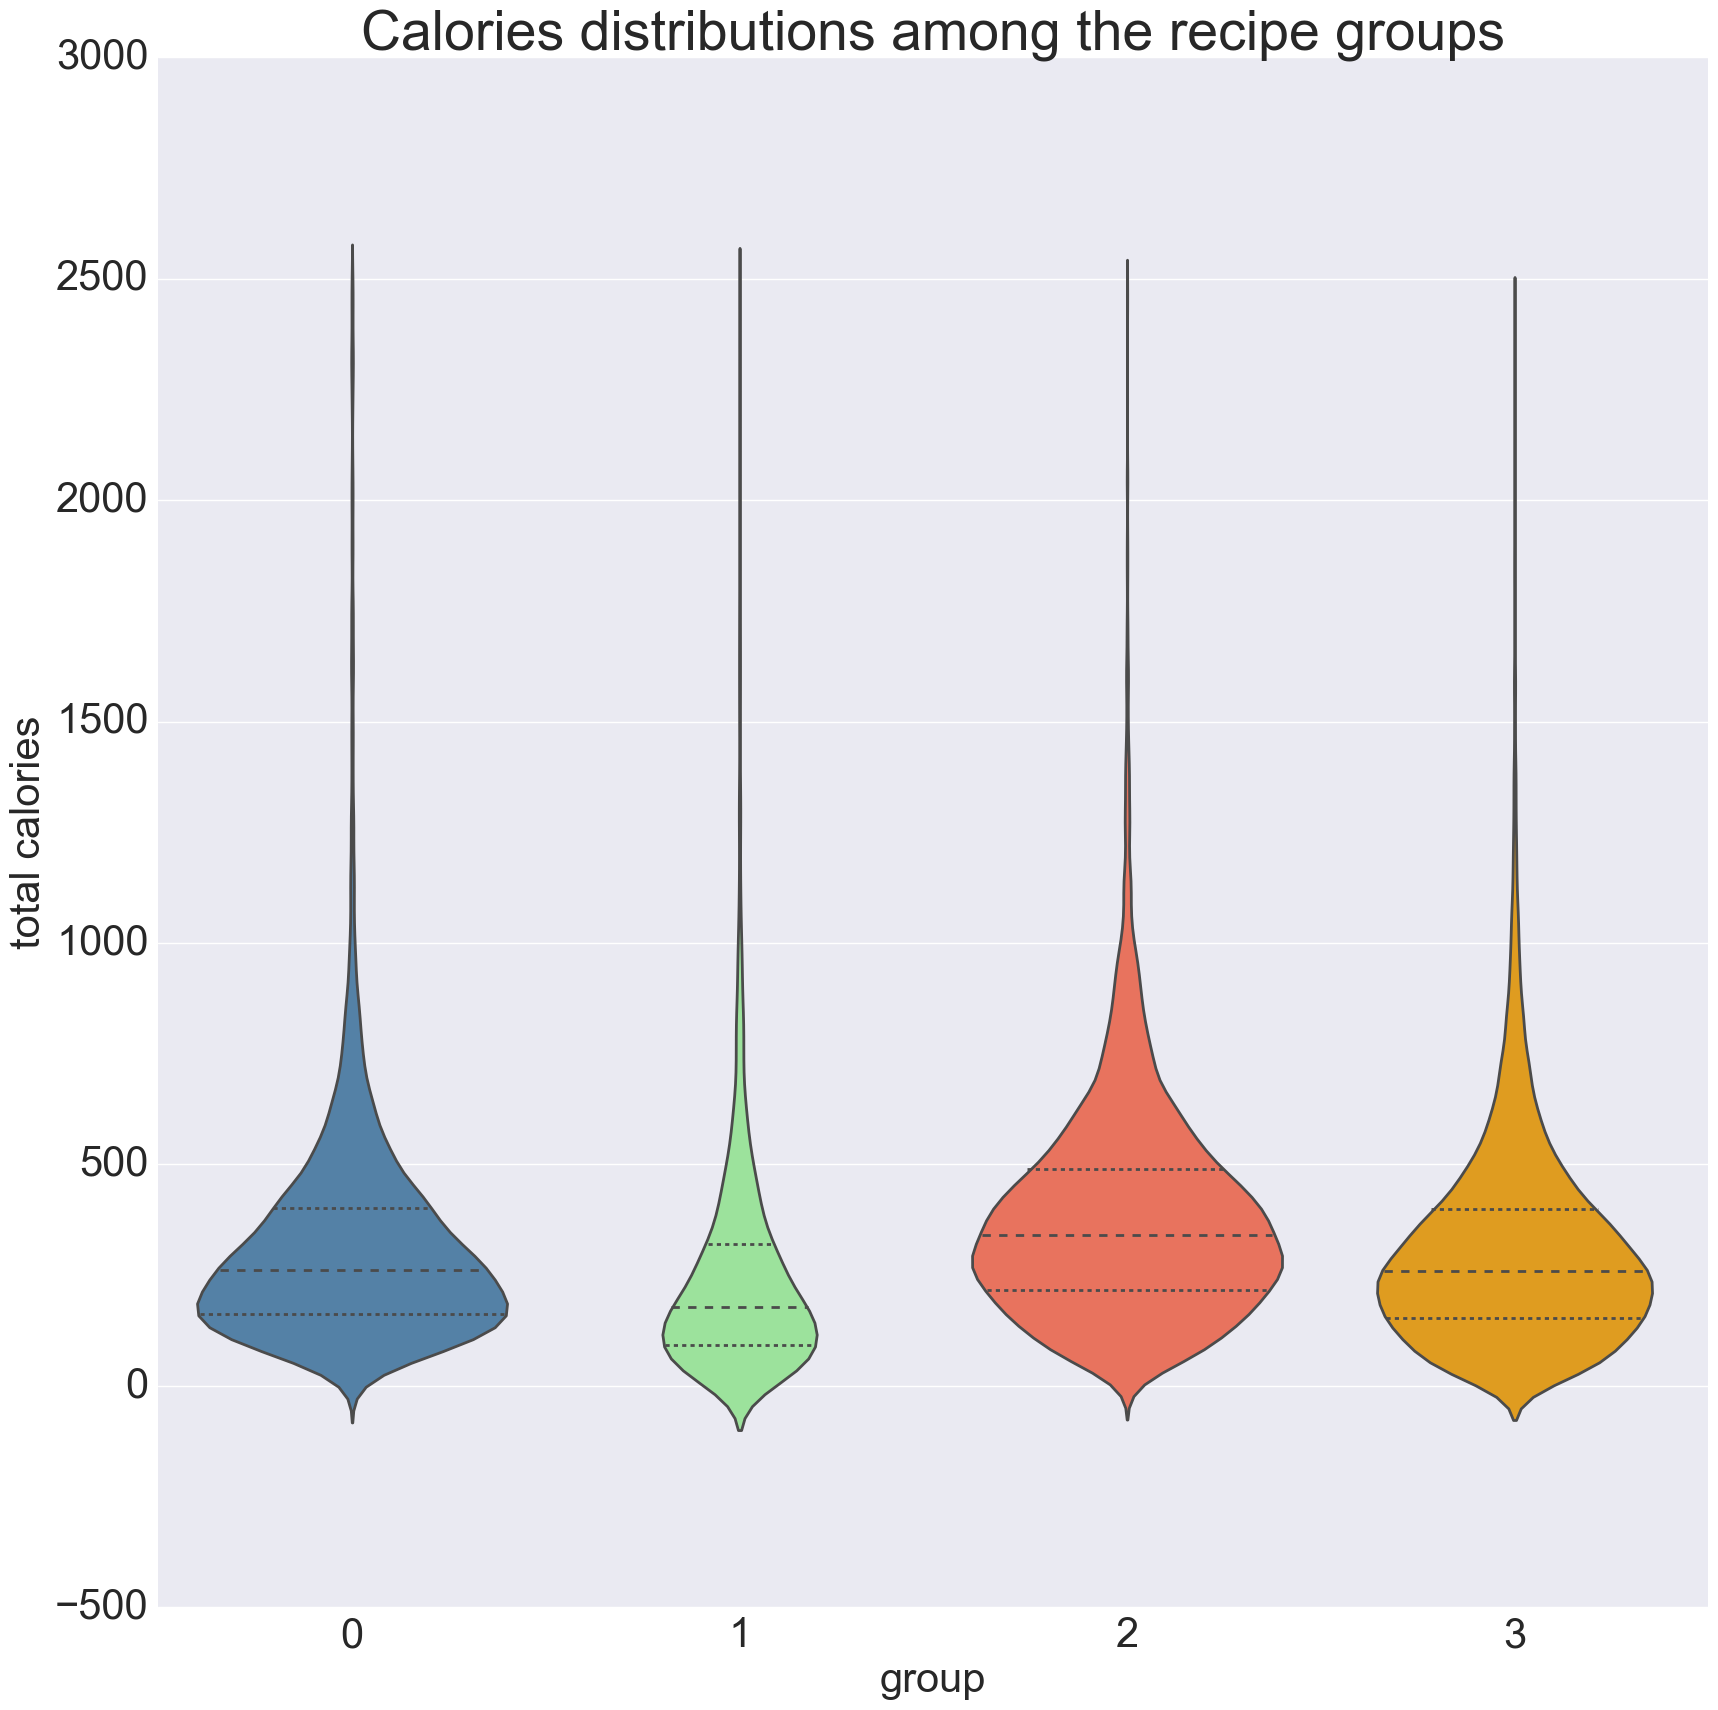

In [20]:
import seaborn as sns
sns.set()
palette = sns.color_palette(group_color)
sns.set_palette(palette)

fig = plt.figure(figsize=(20,20))
sns.violinplot(y='kcal_total',x='group', data=db_recipes, scale='count', inner='quartile', linewidth=2)
plt.tick_params(axis='both', labelsize=30)
plt.xlabel('group',fontsize=30)
plt.ylabel('total calories',fontsize=30)
plt.title('Calories distributions among the recipe groups', fontsize=40)
plt.show()

We see that more complex recipes (0,2) have more calories than their simpler counterparts (respectively 1,3). 

Moreover, quite surprisingly, **main courses recipes** (2,3) **are in average more calorific than dessert recipes** (0,1). They also have more recipes with very high calories, compared to dessert recipes.

This could be linked to desserts often considered full of fats and sugar, thus pushing people to develop and publish a lot of low-fat, low-calories dessert recipes in the 2010's. It also comes with the fact that there are a lot of subtitutes for sugar, milk and eggs.

In [21]:
db_recipes['carb_prop'] = db_recipes['kcal_carb']/db_recipes['kcal_total']
db_recipes['protein_prop'] = db_recipes['kcal_protein']/db_recipes['kcal_total']
db_recipes['fat_prop'] = db_recipes['kcal_fat']/db_recipes['kcal_total']

db_recipes = db_recipes[db_recipes['carb_prop']<1]
db_recipes = db_recipes[db_recipes['protein_prop']<1]
db_recipes = db_recipes[db_recipes['fat_prop']<1]

db_recipes[['carb_prop','protein_prop','fat_prop','ingredients','group']]

,carb_prop,protein_prop,fat_prop,ingredients,group
0,0.856031,0.081712,0.027237,"[chocolate, vanilla, milk]",1
1,0.625000,0.062500,0.328125,"[brown sugar, vanilla, butter, sugar, flour, cream, milk, salt, egg]",0
2,0.087432,0.278689,0.628415,"[mayonnaise, paprika, mustard, pepper, onion, salt, dill, egg]",3
3,0.000000,0.000000,0.000000,"[spearmint, mint]",1
4,0.438746,0.108262,0.447293,"[ice cream, vanilla, milk, mint]",1
...,...,...,...,...,...
34212,0.493243,0.202703,0.304054,"[cream cheese, black pepper, sour cream, mozzarella, artichoke, tortilla, parmesan, spinach, garlic, cheese, chips]",2
34213,0.775000,0.231250,0.043750,"[tomato sauce, peppers, bean]",3
34214,0.499184,0.181077,0.323002,"[olive oil, paprika, chicken, garlic, lemon, bread, bacon, onion, pea]",3
34215,0.503497,0.023310,0.388112,"[mascarpone, cinnamon, red wine, vanilla, butter, cheese, sugar, cream, icing, bean, pear]",1


To study in detail the calories distribution, we cannot compare the raw data of kcal_fat,kcal_carb,kcal_protein because the portions in recipes are not consistent. Even though the data should contained information *per serving*, there is still outliers. We cannot compare a recipe of burgers for 2 people and a chocolate cake for 8 people. **We thus use the proportion of fat, carb and proteins in the total number of calories**.

In [22]:
pd.options.display.max_rows = 34
db_recipes.groupby(db_recipes['group'])[['carb_prop','protein_prop','fat_prop']].describe()

carb_prop  protein_prop      fat_prop
group                                                
0     count  10070.000000  10070.000000  10070.000000
      mean       0.529338      0.084327      0.399171
      std        0.170942      0.069560      0.168810
      min        0.000000      0.000000      0.000000
      25%        0.435238      0.044872      0.297872
      50%        0.542857      0.062323      0.401530
      75%        0.640000      0.100000      0.500000
      max        0.993840      0.981818      0.986667
1     count   4225.000000   4225.000000   4225.000000
      mean       0.526078      0.102939      0.356597
      std        0.271098      0.126395      0.250000
      min        0.000000      0.000000      0.000000
      25%        0.328571      0.029557      0.144665
      50%        0.551237      0.057075      0.357298
      75%        0.728571      0.122807      0.524871
      max        0.998628      0.926094      0.997437
2     count  10088.000000  10088.000000  10088.000000
      mean       0.308828      0.208713      0.485114
      std        0.182844      0.115957      0.186193
      min        0.000000      0.000000      0.000000
      25%        0.162791      0.125347      0.348944
      50%        0.293375      0.190910      0.484123
      75%        0.431295      0.264082      0.618534
      max        0.957447      0.863158      0.987305
3     count   8823.000000   8823.000000   8823.000000
      mean       0.384784      0.228586      0.391163
      std        0.249309      0.150871      0.223145
      min        0.000000      0.000000      0.000000
      25%        0.176146      0.108571      0.219512
      50%        0.357143      0.208000      0.383212
      75%        0.569659      0.317949      0.543945
      max        0.996825      0.871795      0.997297

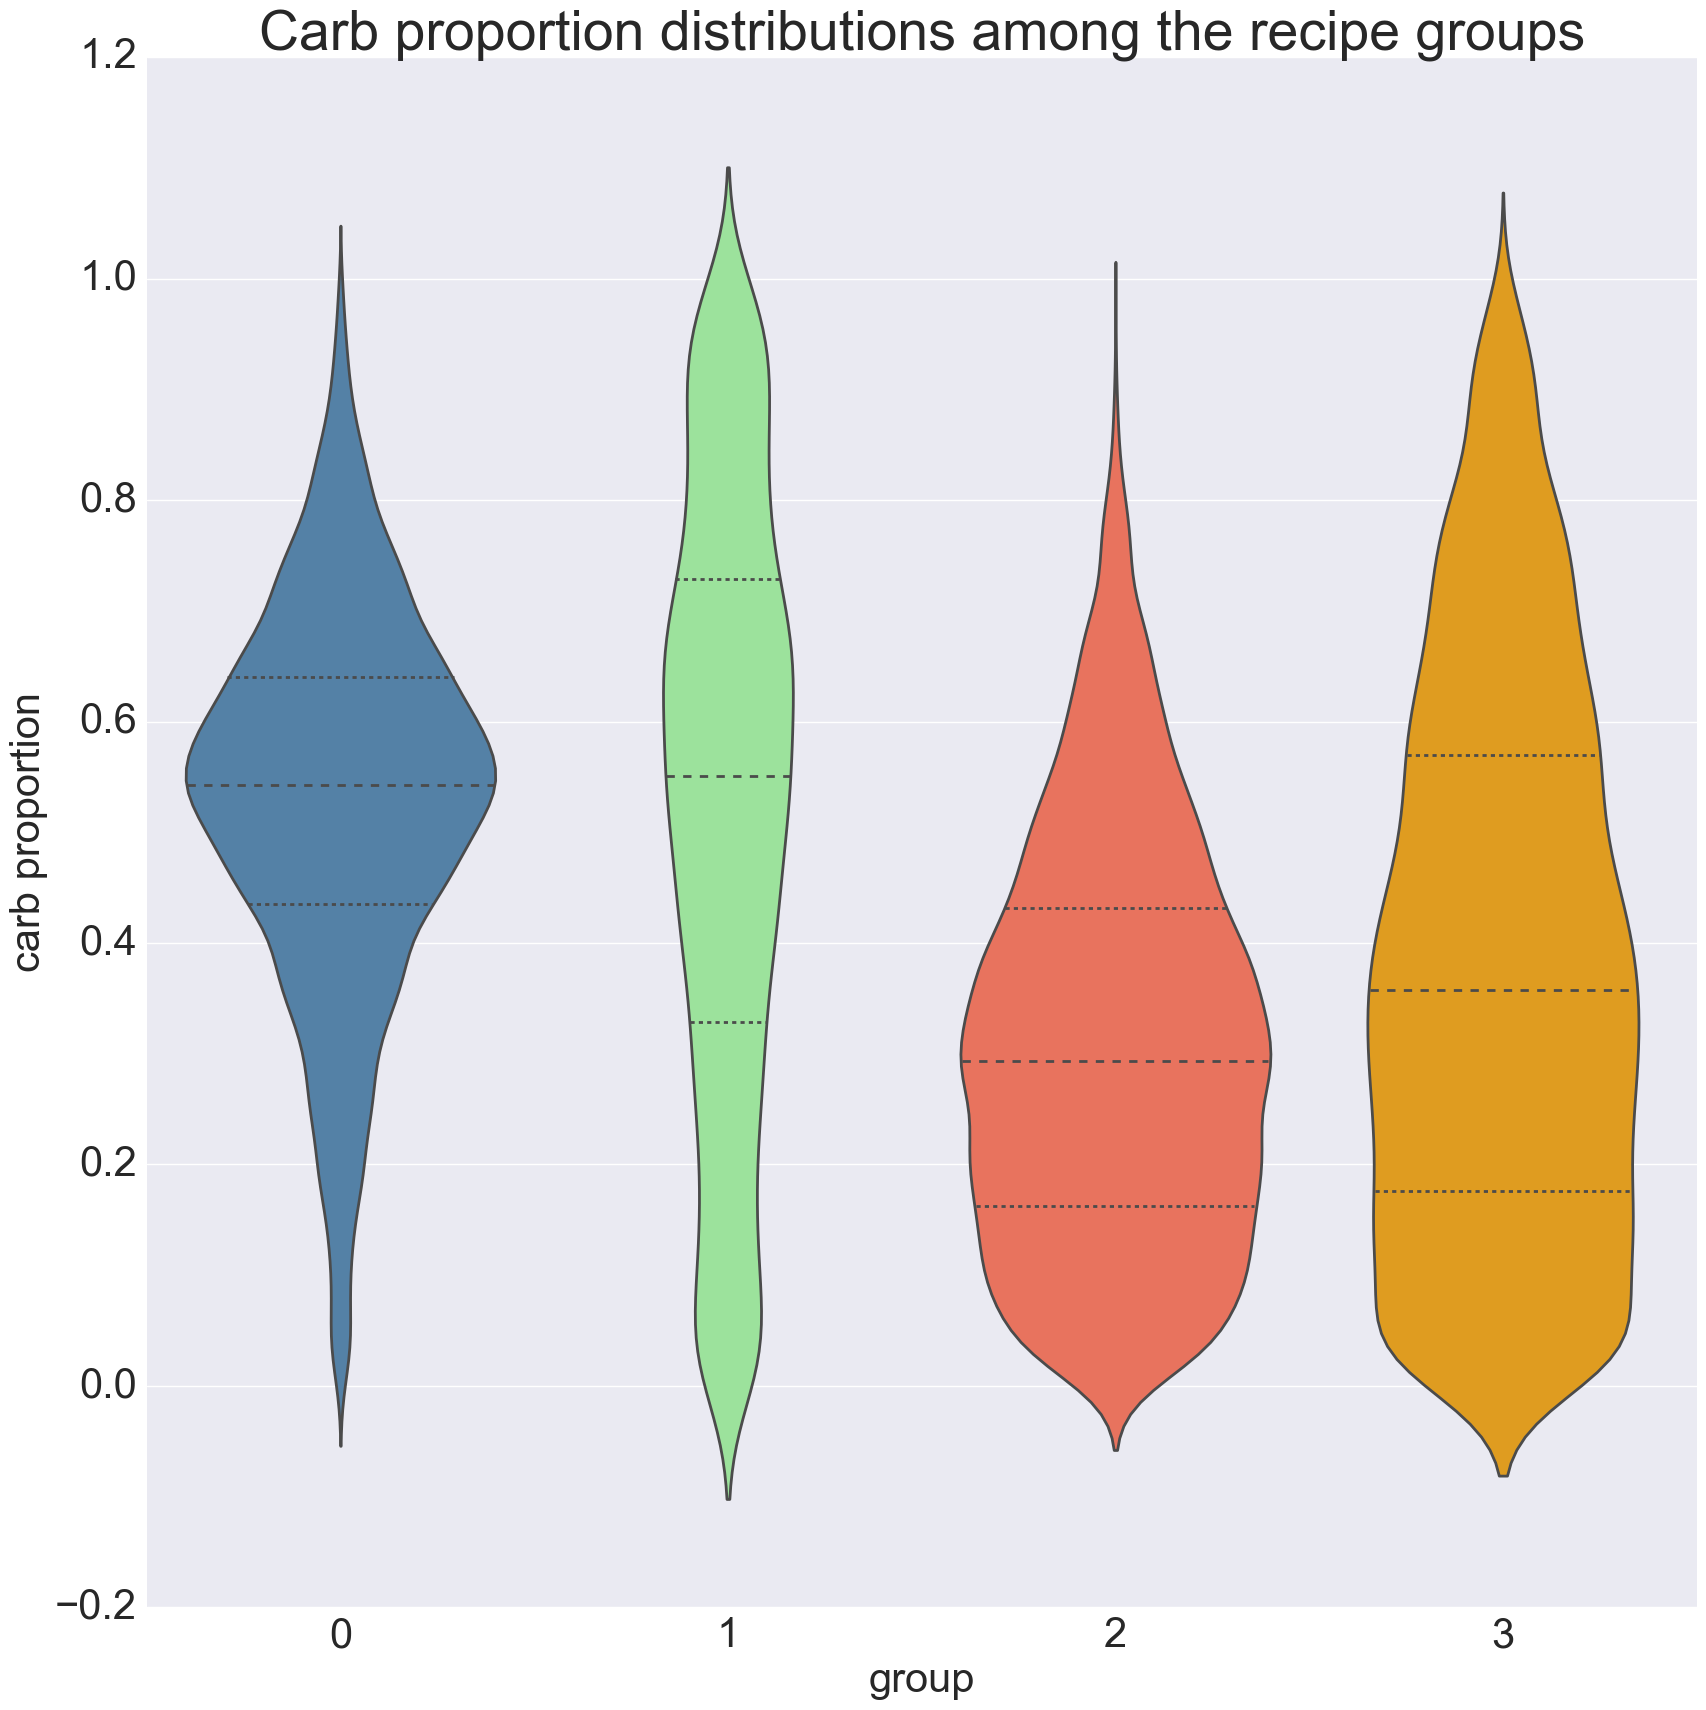

In [23]:
fig = plt.figure(figsize=(20,20))
sns.violinplot(y='carb_prop',x='group', data=db_recipes, scale='count', inner='quartile', linewidth=2)
plt.tick_params(axis='both', labelsize=30)
plt.xlabel('group',fontsize=30)
plt.ylabel('carb proportion',fontsize=30)
plt.title('Carb proportion distributions among the recipe groups', fontsize=40)
plt.show()

We observe very different distributions of the carb proportion:
* group 0 is pretty gathered around its mean, which is quite high. It seems complex desserts have high rates of carbs.
* group 1 is quite regular: there is almost a uniform distribution of carb proportions. Thus simple desserts are not characterized by their carb rate.
* group 2 and 3 have pretty low carb rates compared to the desserts groups. However simple main courses (3) can get to a high rate of carbs.

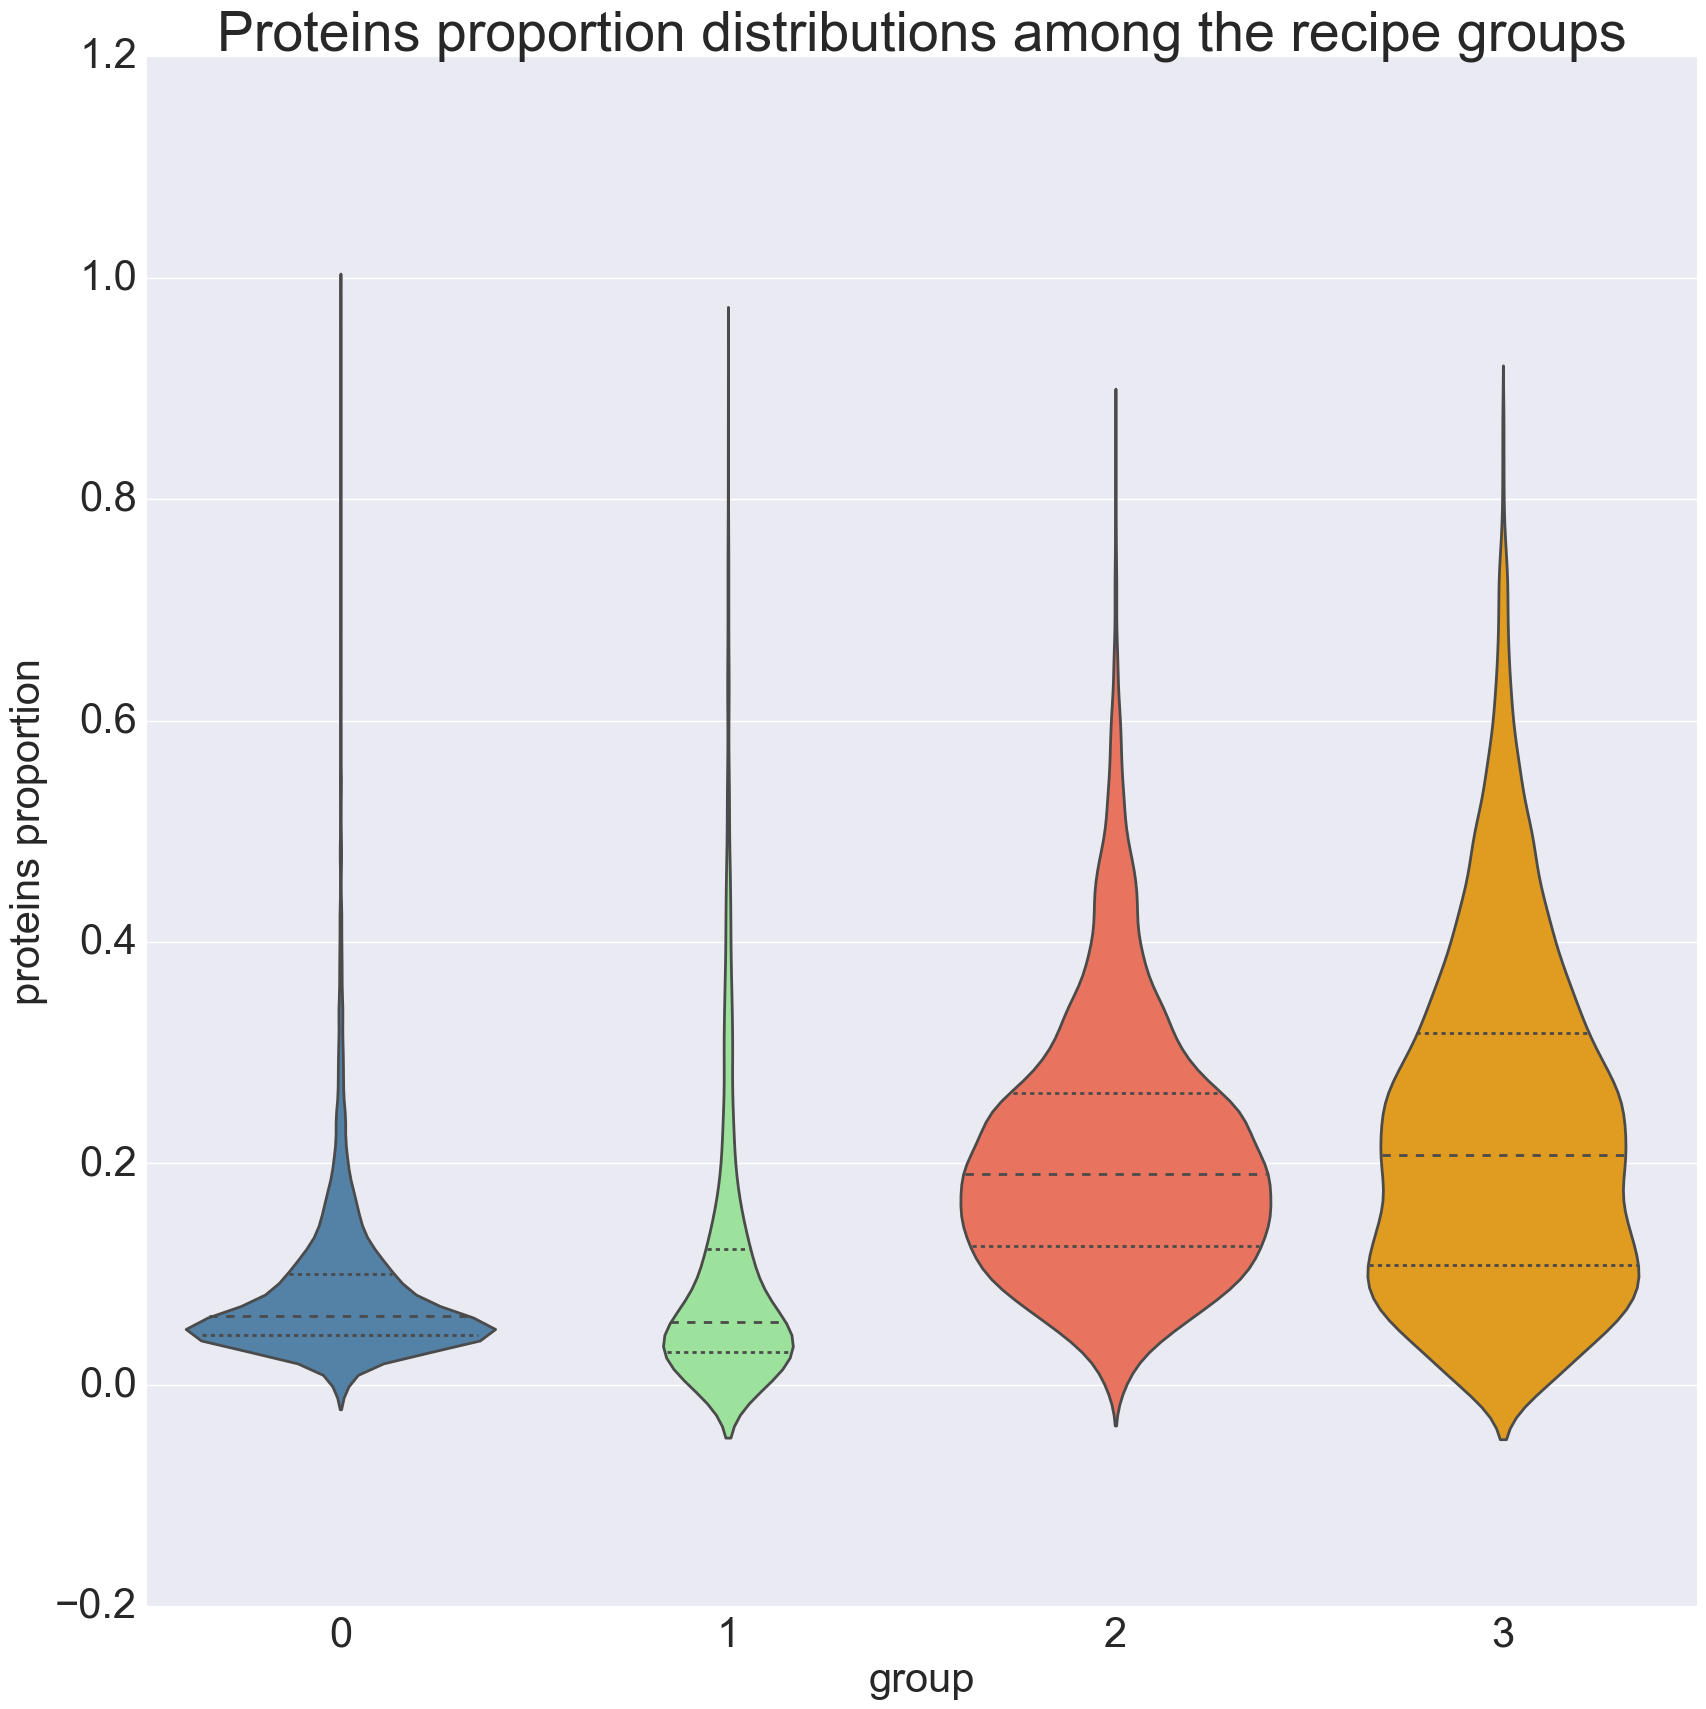

In [24]:
fig = plt.figure(figsize=(20,20))
sns.violinplot(y='protein_prop',x='group', data=db_recipes, scale='count', inner='quartile', linewidth=2)
plt.tick_params(axis='both', labelsize=30)
plt.xlabel('group',fontsize=30)
plt.ylabel('proteins proportion',fontsize=30)
plt.title('Proteins proportion distributions among the recipe groups', fontsize=40)
plt.show()

For the proteins distribution, we can observe a great distinction between the desserts (0,1) and the main courses (2,3). The desserts have very low rates of proteins, and very centered around the mean.

The proteins proportion is sparse for the 2nd group, and even more spread for the 3rd group.

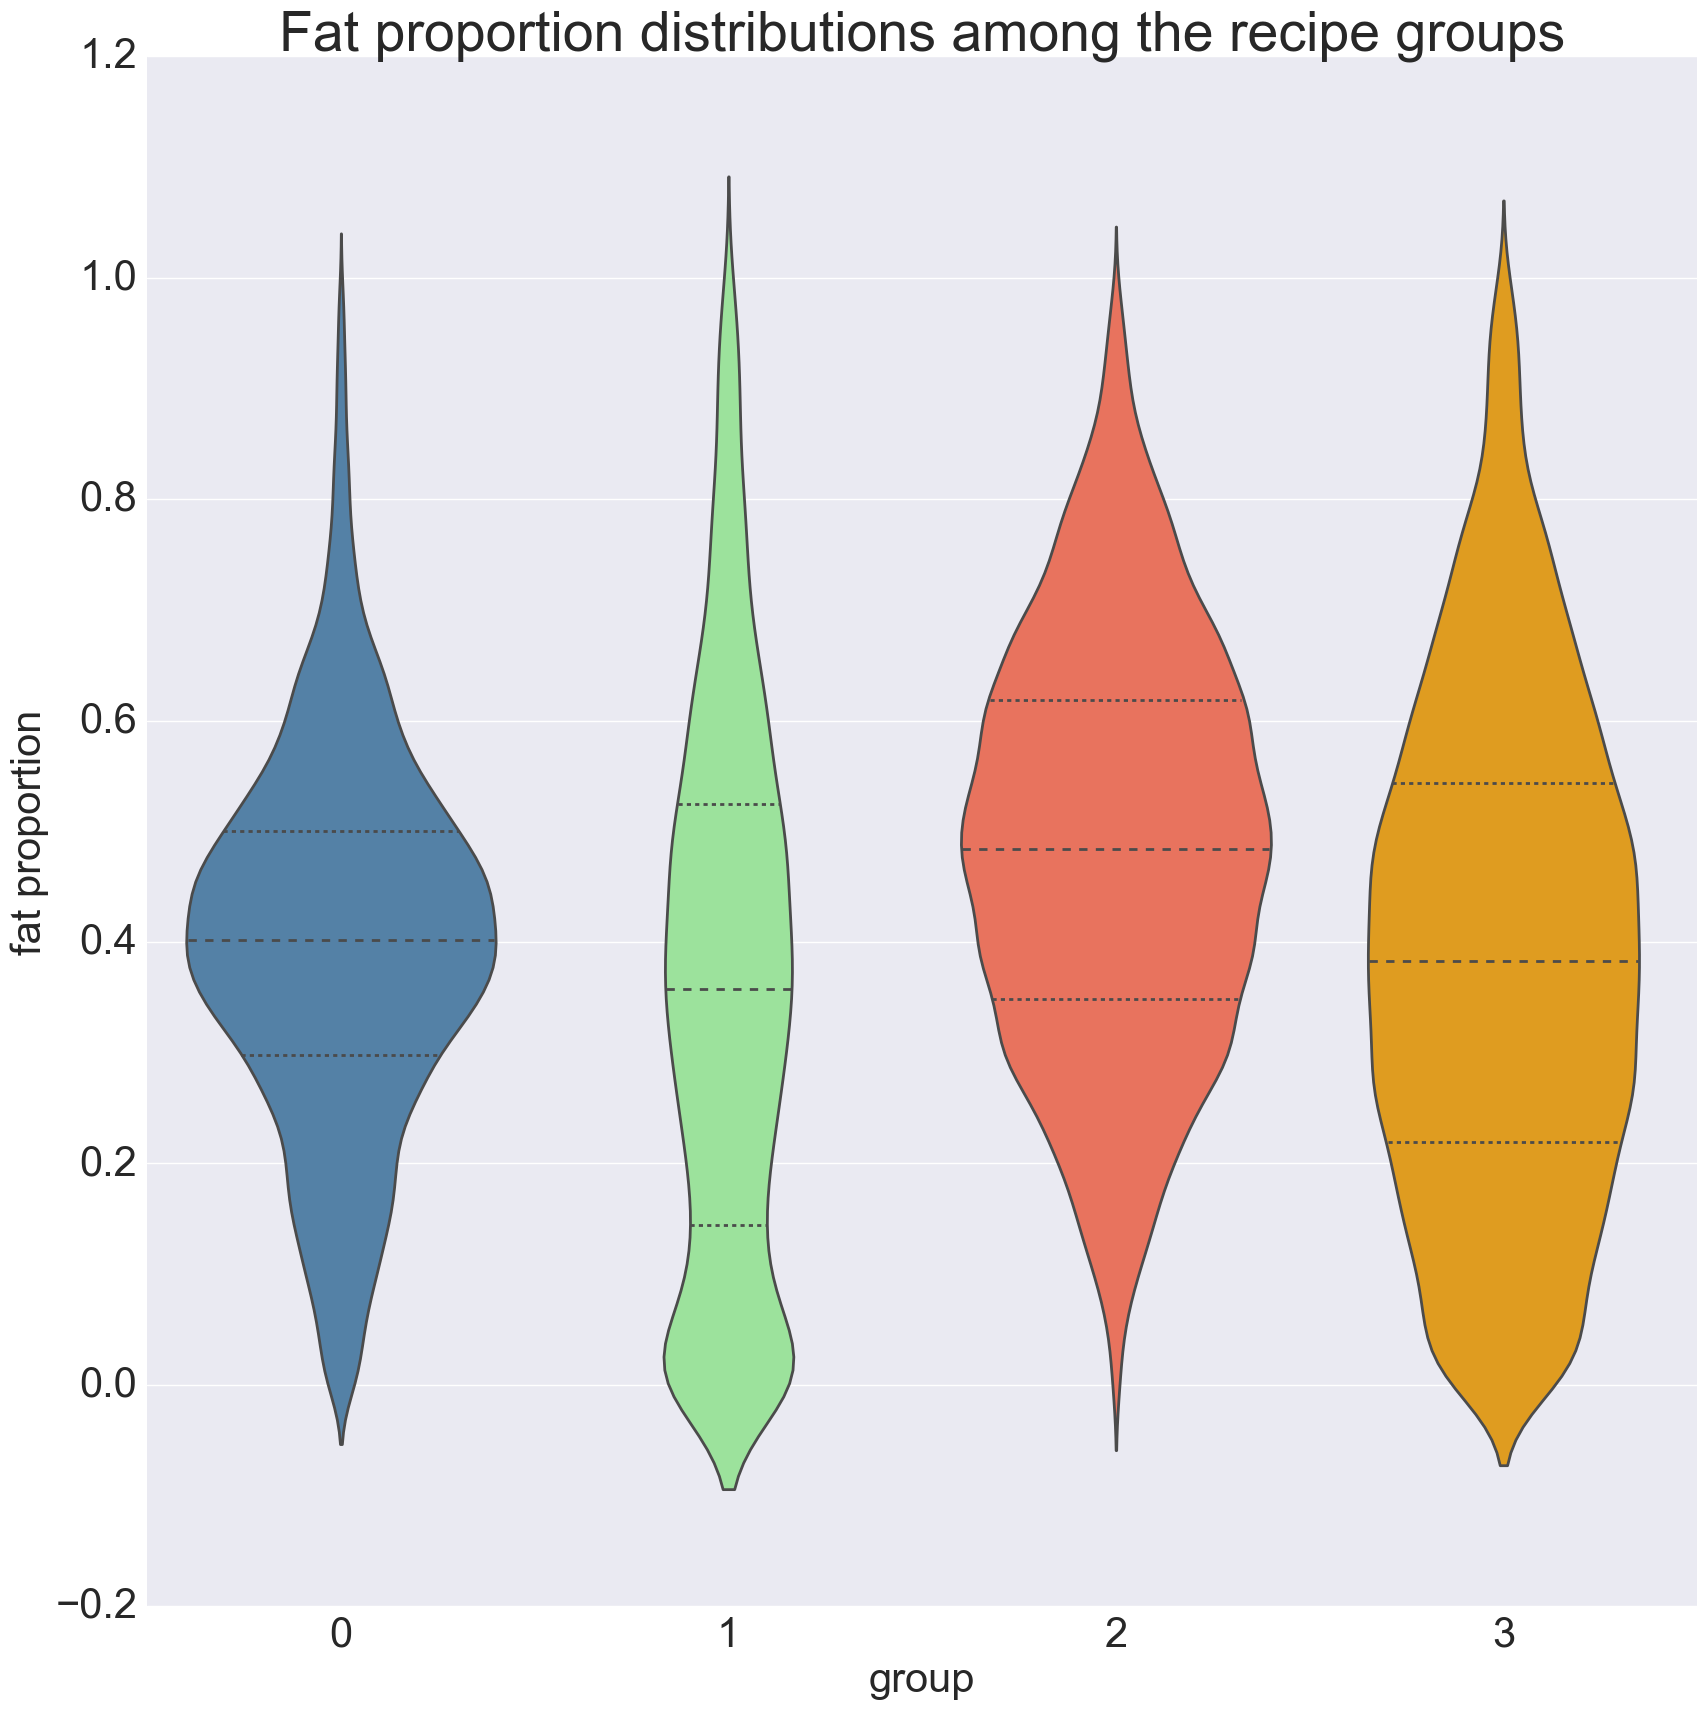

In [25]:
fig = plt.figure(figsize=(20,20))
sns.violinplot(y='fat_prop',x='group', data=db_recipes, scale='count', inner='quartile', linewidth=2)
plt.tick_params(axis='both', labelsize=30)
plt.xlabel('group',fontsize=30)
plt.ylabel('fat proportion',fontsize=30)
plt.title('Fat proportion distributions among the recipe groups', fontsize=40)
plt.show()

The fat proportions are quite different among groups too. For group 1, the distribution is relatively uniform, a bit "squeezed" aroun the first quartile.

The distribution for group 0 is symmetric around the mean at 0.4, whereas distributions for groups 2,3 are more spread.

We also observe that complex recipes (0,2) have in average a higher fat rate than more simpler recipes (1,3).

## Propensity scores to assess the characterization

We will use logistic regression on the 2 following attributes: 'is main course?' and 'is simple?'.

It is relevant here because we can cut our 4 groups according to those 2 treatments:
* group 0 corresponds to 0,0
* group 1 corresponds to 0,1
* group 2 corresponds to 1,0
* group 3 corresponds to 1,1

Thus we apply two logistic regressions and obtain propensity scores corresponding to the 2 treatments.

In [26]:
from sklearn import linear_model

# Logistic for dessert=0, main course=1
logistic = linear_model.LogisticRegression()

db_X = db_recipes[['protein_prop','carb_prop','fat_prop']]
db_y = db_recipes['group'].apply(lambda x: 0 if x in [0,1] else 1)

logistic = logistic.fit(db_X, db_y)

prop_score = logistic.predict_proba(db_X)[:,1]
db_recipes['is_main_course'] = prop_score

# Logistic for complex=0, simple=1
logistic = linear_model.LogisticRegression()

db_X = db_recipes[['protein_prop','carb_prop','fat_prop']]
db_y = db_recipes['group'].apply(lambda x: 0 if x in [0,2] else 1)

logistic = logistic.fit(db_X, db_y)

prop_score = logistic.predict_proba(db_X)[:,1]
db_recipes['is_simple'] = prop_score

db_recipes[['group','is_main_course','is_simple']].head()

,group,is_main_course,is_simple
0,1,0.204700,0.479157
1,0,0.280976,0.365823
2,3,0.931209,0.383352
3,1,0.235476,0.646270
4,1,0.492239,0.356375


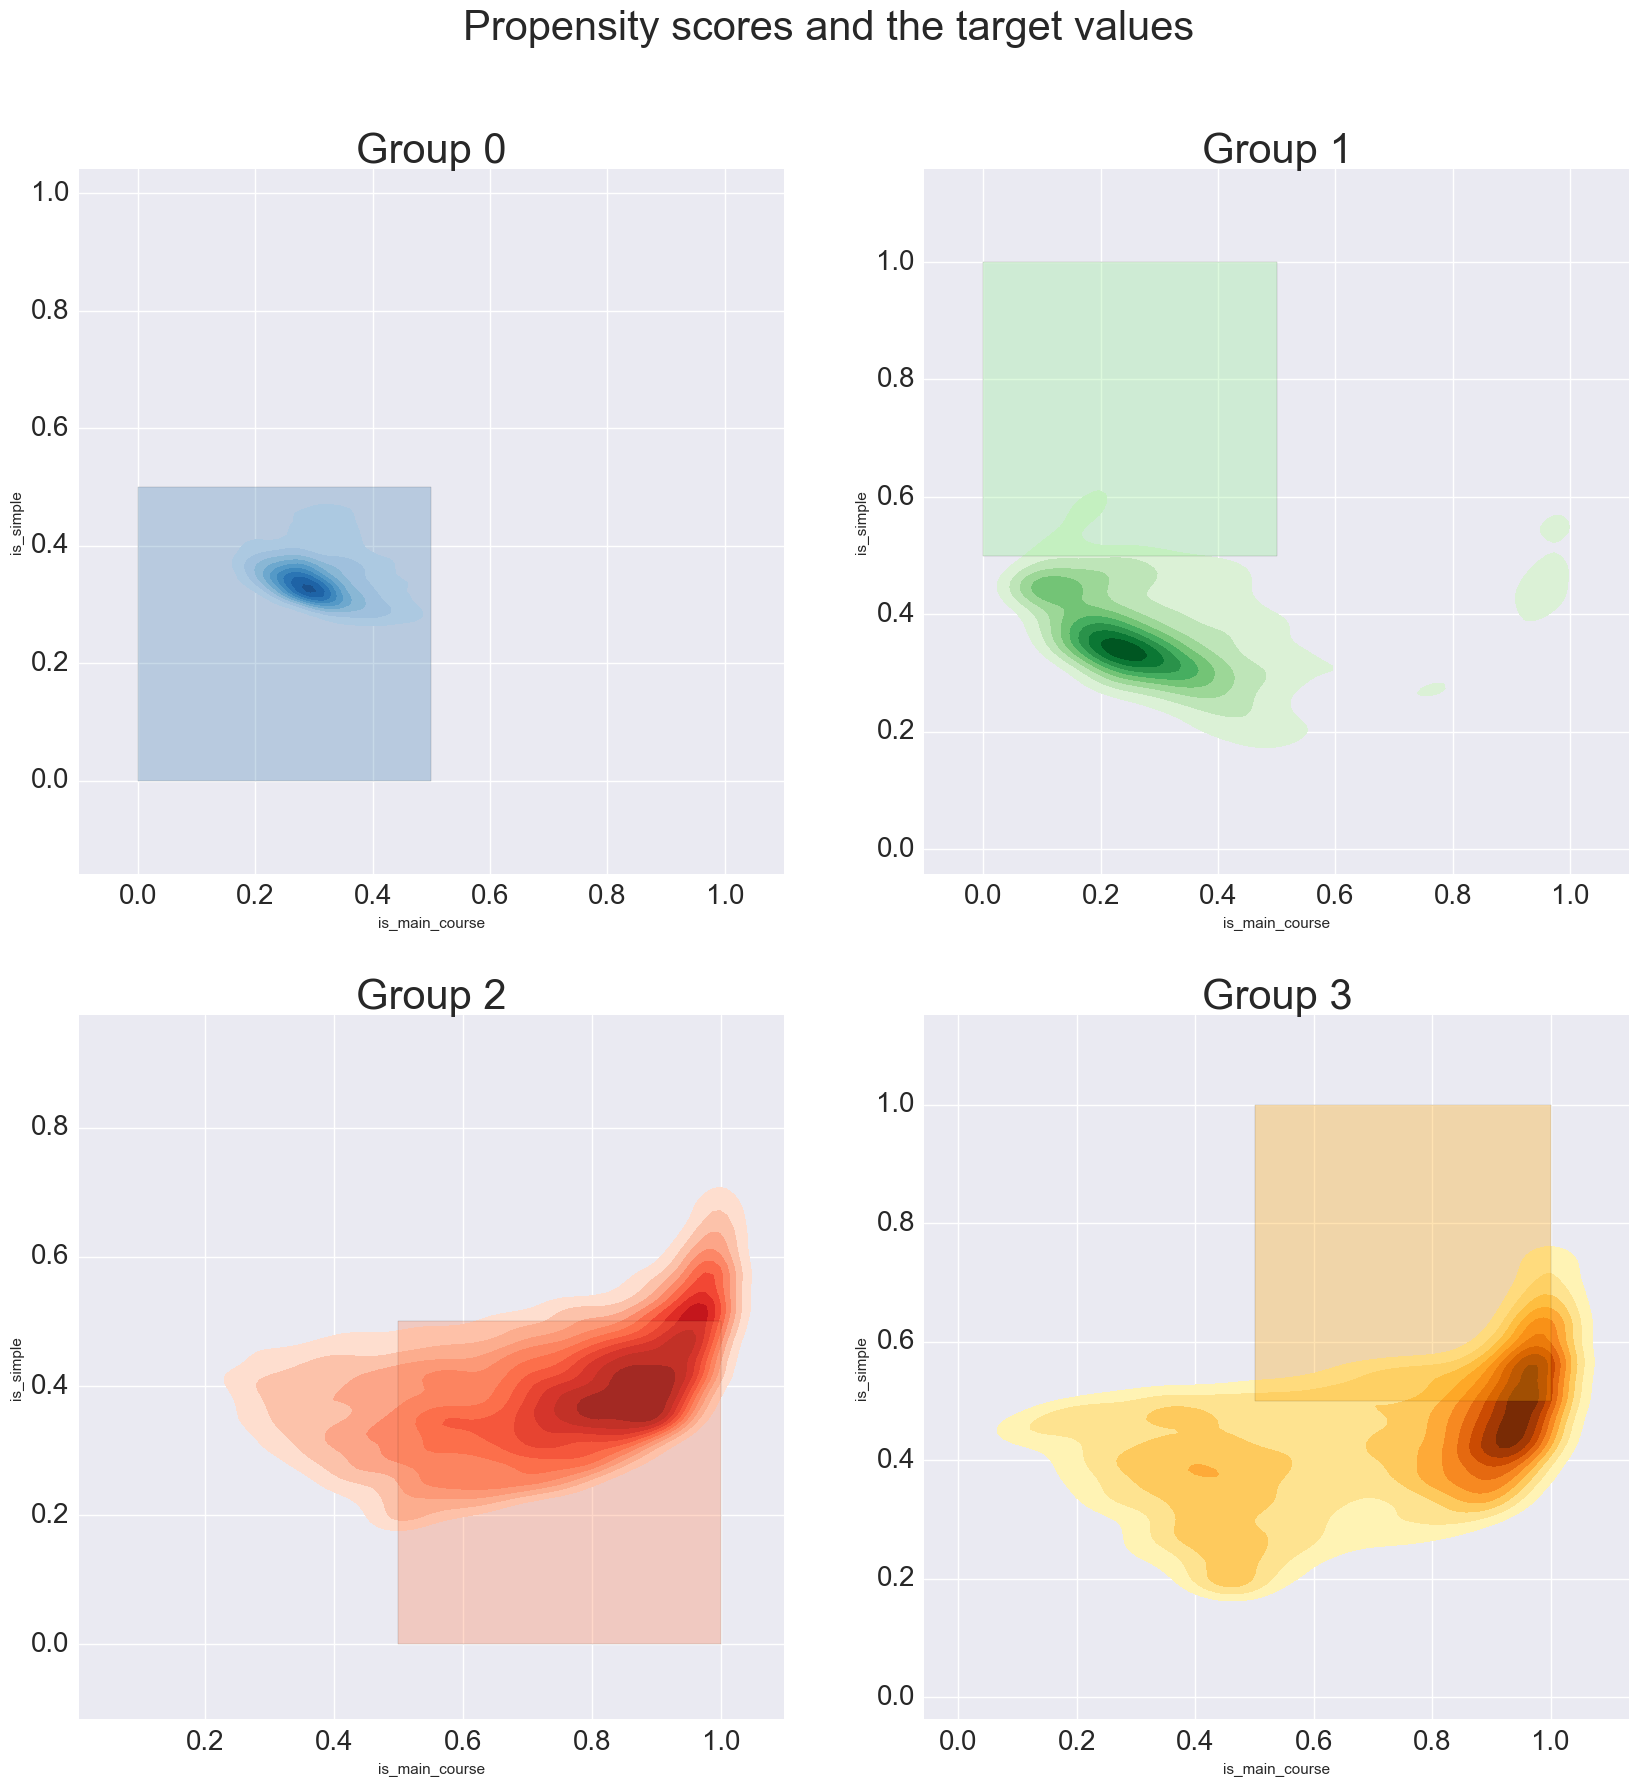

In [27]:
db_0 = db_recipes[db_recipes['group']==0]
db_1 = db_recipes[db_recipes['group']==1]
db_2 = db_recipes[db_recipes['group']==2]
db_3 = db_recipes[db_recipes['group']==3]

f,((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(20,20))

f.suptitle("Propensity scores and the target values", fontsize=30)

ax0.axis('equal')
ax0.set_xlim(-0.1,1.1)
ax0.add_patch(patches.Rectangle((0, 0), 0.5, 0.5,alpha=0.3,facecolor='steelblue'))
sns.kdeplot(db_0['is_main_course'],db_0['is_simple'],cmap="Blues",n_levels=10,shade=True,ax=ax0)
ax0.collections[0].set_alpha(0)
ax0.tick_params(axis='both', labelsize=20)
ax0.set_title('Group 0', fontsize=30)

ax1.axis('equal')
ax1.set_xlim(-0.1,1.1)
ax1.add_patch(patches.Rectangle((0, 0.5), 0.5, 0.5,alpha=0.3,facecolor='lightgreen'))
sns.kdeplot(db_1['is_main_course'],db_1['is_simple'],cmap="Greens",n_levels=10,shade=True,ax=ax1)
ax1.collections[0].set_alpha(0)
ax1.tick_params(axis='both', labelsize=20)
ax1.set_title('Group 1', fontsize=30)

ax2.set_xlim(-0.1,1.1)
ax2.axis('equal')
ax2.add_patch(patches.Rectangle((0.5, 0), 0.5, 0.5,alpha=0.3,facecolor='coral'))
sns.kdeplot(db_2['is_main_course'],db_2['is_simple'],cmap="Reds",n_levels=10,shade=True,ax=ax2)
ax2.collections[0].set_alpha(0)
ax2.tick_params(axis='both', labelsize=20)
ax2.set_title('Group 2', fontsize=30)

ax3.set_xlim(-0.1,1.1)
ax3.axis('equal')
ax3.add_patch(patches.Rectangle((0.5, 0.5), 0.5, 0.5,alpha=0.3,facecolor='orange'))
sns.kdeplot(db_3['is_main_course'],db_3['is_simple'],cmap="YlOrBr",n_levels=10,shade=True,ax=ax3)
ax3.collections[0].set_alpha(0)
ax3.tick_params(axis='both', labelsize=20)
ax3.set_title('Group 3', fontsize=30)

plt.show()

On this plot, we realize mainly two things:
* the distinction main course/ dessert is pretty clear: groups 0 and 1 are both clearly identified as desserts. For groups 2 and 3, there is a residual tail but the main part is identified as main course
* however the distinction between simple and complex recipes is not as correct. We see recipes are mostly considered simple, even if group 3 is not that far of being identified. Group 1 is quite out of the target zone.

## Conclusion

The classification via k-means clustering makes sense regarding the ingredients of the recipes. Grouping according to the food groups each recipe covers is relevant as it distinguishes clearly different groups of food usually cooked together. 

As shown in the study and with the propensity scores, the fat/carb/protein characterization is possible and valid to distinguish between the desserts and the main courses. The distributions are pretty different among those groups and the characterization makes sense.

However, when it comes to distinguish between complex and simple recipes (the classification is a bit more complex but can be summed up this way), the differences in fat/carb/protein distribution are not that clear, and the characterazition is more complicated.